# Objective
#### Determine whether the given reviews are positive or negative using all features except SCORE and then check the accuracy using the Score feature using KNN classifier

# 1. Loading data from dataset

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import nltk
import seaborn as sns
from tqdm import tqdm

In [2]:
# Loading data from sqlite3 database ignoring those having rewiew score = 3

connection = sqlite3.connect('./database.sqlite')
dataset = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", connection)

In [3]:
print("The shape of the data in dataset is:", dataset.shape)
print('==' * 60)
dataset.columns                # This will list all the features name in dataset column-wise

The shape of the data in dataset is: (525814, 10)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [4]:
# Assigning Positive value to reviews with score>3 and Negative value to reviews with score<3

def assign_pn(score):
    if (score > 3):
        score = 'Positive'
    elif (score < 3):
        score = 'Negative'
    return score

pn = dataset['Score']
pn_assign = pn.map(assign_pn)
dataset['Score'] = pn_assign

In [5]:
print(dataset['Score'].value_counts() )                       # Printing the number of each classes (positive and negative reviews)
print('==' * 60)
print("The shape of the data in dataset is:", dataset.shape)

Positive    443777
Negative     82037
Name: Score, dtype: int64
The shape of the data in dataset is: (525814, 10)


In [6]:
# Printing first few rows as a sample of the dataset
# You may pass the number of rows to be displayed as an argument to the head() method

dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Pre-processing of data

### 2.1 De-duplication of data

In [7]:
# Sorting data based on ProductId

sorted_data = dataset.sort_values('ProductId', ascending=True, axis=0)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [8]:
# Remove all the data points that exactly match the field values mention below

data = sorted_data.drop_duplicates(subset={'UserId', 'Time', 'Text'}, keep='first', inplace=False)
data.shape

(364133, 10)

In [9]:
# Check what percentage of original data is remaining

percentage = (data.shape[0] / dataset.shape[0]) * 100
print(percentage)

69.25129418387492


In [10]:
# Removing the reviews having HelpfulnessNumerator greater than HelpfulnessDenominator

data = data[data.HelpfulnessDenominator >= data.HelpfulnessNumerator]
data.shape

(364131, 10)

Positive    307026
Negative     57105
Name: Score, dtype: int64

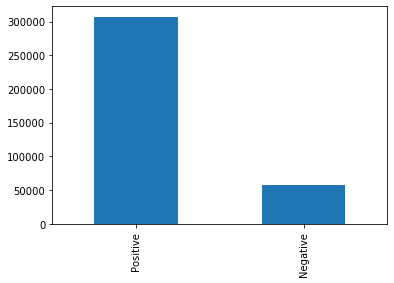

In [11]:
# Getting the number of positive and negative reviews

data['Score'].value_counts().plot(kind='bar')
data['Score'].value_counts()

### 2.2 Data Cleaning

In [12]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [13]:
# Find sentences containing html tags

i = 0
for sentence in data['Text'].values:
    if (len(re.findall('<.*?>', sentence))):
        print("Total number of html tags present:", i)
        print("=="*60)
        print(sentence)
        break
    i += 1

Total number of html tags present: 6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:
# Function to remove texts with html tags(<...>)

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')                  # Select ANY text with < > tags
    cleanText = re.sub(cleanr, ' ', sentence)     # Replace texts enclosed in < > with white space
    return cleanText

In [15]:
# Function to remove punctuation marks(.,?/:;)

def cleanPunctuation(sentence):
    cleanp = re.sub(r'[?|$|.|!]',r'', sentence)
    cleanp = re.sub(r'[.|,|)|(|\|/]',r' ', cleanp)
    return cleanp

In [16]:
# Printing the set of stop words present in english language
# You need to download stopword first before using it(import nltk; nltk.download("stopwords");)

stopWords = set(stopwords.words('english'))
print(stopWords)

{'below', 'against', 're', 'yours', "that'll", 'y', 'the', 'been', 't', 'those', 'her', "didn't", 'they', "should've", 'needn', 'into', 'from', 'me', 'have', 'whom', 'do', 'our', 'most', "couldn't", "weren't", 'up', 'if', 'then', 'own', 'than', 'some', 'what', 'is', 'or', 'we', 'until', "hadn't", 'themselves', 'their', "wouldn't", 'under', 'you', "don't", 'all', 'because', 'mustn', 'and', 'as', 'just', "you'll", 'has', 'o', 'd', 'wasn', "you'd", 'about', 'hadn', 'in', 'haven', 'am', 'don', "you're", 'having', 'should', "shouldn't", 'his', 'weren', 'nor', 'no', 'which', 'at', 'i', 'again', 'ma', "mightn't", 'being', 'each', 'very', 'there', 'hasn', 'it', "wasn't", 'with', 'himself', 'of', 'why', 'isn', 'who', 'that', 'hers', "aren't", 'couldn', 'herself', 'other', 'while', 'between', 'did', 'ain', 'doesn', 'above', 'shouldn', 'll', 'my', 'its', 'too', 'aren', 'further', 'itself', 'yourself', 'are', 'how', 'your', 'ourselves', "doesn't", "isn't", 'after', "shan't", 'was', 'mightn', 'he',

In [17]:
# Initializing SnowBall Stemmer

snowball = SnowballStemmer('english')

In [18]:
# Printing a base-word using snowball stemmer

print(snowball.stem('tasty'))
print(snowball.stem('delicious'))
print(snowball.stem('little'))

tasti
delici
littl


In [19]:
# Core Pre-processing code step-by-step(removing html tags, punctuations, stopwords, etc)
# This may take a few minutes to execute as it needs to execute all the sentences present in data['Text']

i = 0
initial_str = ''
final_str = []          # Store final string of clean words
positive_words = []     # Store words from positive reviews here
negative_words = []     # Store words from negative reviews here
s = ''

for sentence in tqdm(data['Text'].values):
    filtered_sentence = []
    sentence = cleanHtml(sentence)          # Remove html tags
    for words in sentence.split():
        for word in cleanPunctuation(words).split():
            if ((word.isalpha()) & (len(word) > 2)):
                if (word.lower() not in stopWords):
                    s = (snowball.stem(word.lower()).encode('utf-8'))
                    filtered_sentence.append(s)
                    if ((data['Score'].values)[i] == 'Positive'):
                        positive_words.append(s)
                    if ((data['Score'].values)[i] == 'Negative'):
                        negative_words.append(s)
                else:
                    continue
            else:
                continue
    initial_str = b" ".join(filtered_sentence)      # Final string of clean words
    final_str.append(initial_str)
    i += 1

100%|██████████| 364131/364131 [05:11<00:00, 1170.75it/s]


In [20]:
# Adding a column in dataset and storing cleaned text in it.

data['CleanedText'] = final_str
data['CleanedText'] = data['CleanedText'].str.decode("utf-8")

In [21]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


# 3. Time-based splitting of data

In [22]:
# Sorting data based on time

time_sort = data.sort_values('Time', ascending=True, axis=0, na_position='last')       # na_postion='last' puts NaNs at the end
time_sort.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# Splitting data into Train, Test and Cross-validation

X = time_sort['CleanedText']
Y = time_sort['Score']

x_training, x_test, y_training, y_test= train_test_split(X, Y, test_size=0.25)
x_train, x_cv, y_train, y_cv = train_test_split(x_training, y_training, test_size=0.3)

In [25]:
print("The shape of the training data is:", x_train.shape, y_train.shape)
print("The shape of the CV data is:", x_cv.shape, y_cv.shape)
print("The shape of the test data is:", x_test.shape, y_test.shape)

The shape of the training data is: (191168,) (191168,)
The shape of the CV data is: (81930,) (81930,)
The shape of the test data is: (91033,) (91033,)


# 4. Function to Train and Test Random Forest models

In [26]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### 4.1 Train function for Random Forest models

In [66]:
def rf_train(x_train, x_cv, y_train, y_cv):
    estimators = [x for x in range(100, 601, 100)]
    depth = [x for x in range(2, 15, 2)]
    accuracy_cv = []

    for i in estimators:
        for j in depth:
            rf = RandomForestClassifier(n_estimators=i, max_depth=j, class_weight='balanced', n_jobs=-1)
            rf.fit(x_train, y_train)

            prediction = rf.predict(x_cv)

            acc_cv = accuracy_score(y_cv, prediction)
            f1_cv = f1_score(y_cv, prediction, average='macro')
            precision_cv = precision_score(y_cv, prediction, average='macro')
            recall_cv = recall_score(y_cv, prediction, average='macro')

            print("FOR estimators =", i, "and depth =", j)
            print("The accuracy of the model is:", acc_cv*100)
            print("The f1_score of the model is:", f1_cv*100)
            print("The precision_score of the model is:", precision_cv*100)
            print("The recall_score of the model is:", recall_cv*100)
            print("=="*60)

            accuracy_cv.append(acc_cv)

    # Plot Hyperparameters(samples/depth) vs auc_score graph
#     plt.plot(samples, accuracy_cv, 'b-', label="Samples")
#     plt.plot(depth, accuracy_cv, 'r-', label="Depth")
#     plt.legend(loc='lower right')
#     plt.title("Hyperparameters(Samples/Depth) v/s Auc Score")
#     plt.ylabel('Auc Score')
#     plt.xlabel('Samples/Depth')
#     plt.show()
    
    # Plot Heatmap for accuracy score
    cmap=sns.color_palette()
    print("---------- Representation of CV Accuracy Score in Heatmap ----------")
    accuracy_cv = np.array(accuracy_cv)
    accuracy_cv = accuracy_cv.reshape(len(depth), len(estimators))
    plt.figure(figsize=(10, 5))
    sns.heatmap(accuracy_cv, annot=True, cmap=cmap, fmt=".4f", xticklabels=estimators, yticklabels=depth)
    plt.xlabel('Number of Estimators')
    plt.ylabel('Depth')
    plt.show()

### 4.2 Test function for Random Forest models

In [28]:
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix

In [67]:
def rf_test(x_train, y_train, x_test, y_test, optimal_estimators, optimal_depth):
    rf = RandomForestClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth, class_weight='balanced', n_jobs=-1)
    rf.fit(x_train, y_train)
    
    prediction = rf.predict(x_test)

    print("The accuracy of the model is:", accuracy_score(y_test, prediction)*100)
    print("The macro f1_score of the model is:", f1_score(y_test, prediction, average = 'macro')*100)
    print("The micro f1_score of the model is:", f1_score(y_test, prediction, average = 'micro')*100)
    print("The precision_score of the model is:", precision_score(y_test, prediction, average='macro')*100)
    print("The recall_score of the model is:", recall_score(y_test, prediction, average='macro')*100)
    print("The precision recall report for data:\n", classification_report(y_test, prediction))
    
    plot_confusion_matrix(y_test, prediction)
    plt.show()

### 4.3 Top 20 Features of Random Forest models

In [30]:
from wordcloud import WordCloud

In [73]:
def top_features(x_train, y_train, vectorizer, optimal_estimators, optimal_depth):
    n = 20
    features = []
    all_features = vectorizer.get_feature_names()
    model = RandomForestClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth, class_weight='balanced', n_jobs=-1)
    model.fit(x_train, y_train)
    coefs = sorted(zip(model.feature_importances_, all_features))
    top = coefs[:-(n + 1):-1]
    
    print('\033[1m' + "Feature Importance \t Features" + '\033[0m')
    print("="*35)
    
    for (coef1, feat1) in top:
        print("%.4f\t\t\t%-2s" % (coef1, feat1))
        features.append(feat1)
    
    wordcloud = WordCloud(background_color='black', width=1200, height=600).generate(" ".join(features))
    fig = plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# 5. Vectorization of splitted of data

### 5.1 Bag of Words (BoW)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
count_vect = CountVectorizer(ngram_range=(1,2))
count_vect.fit(x_train)
# Fit should be done only to train data
# After fitting count_vect only learns the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_bow = count_vect.transform(x_train)
x_cv_bow = count_vect.transform(x_cv)
x_test_bow = count_vect.transform(x_test)

In [34]:
print("The shape of the training data is:", x_train_bow.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_bow.shape, y_cv.shape)
print("The shape of the test data is:", x_test_bow.shape, y_test.shape)

The shape of the training data is: (191168, 1933864) (191168,)
The shape of the CV data is: (81930, 1933864) (81930,)
The shape of the test data is: (91033, 1933864) (91033,)


### 5.2 Term Frequency - Inverse Document Frequency (tf-idf)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
tfidf_vect = TfidfVectorizer(stop_words=None, ngram_range=(1,2))
tfidf_vect.fit(x_train)
# Fit should be done only to train data
# After fitting tfidf_vect only learnss the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_tfidf = tfidf_vect.transform(x_train)
x_cv_tfidf = tfidf_vect.transform(x_cv)
x_test_tfidf = tfidf_vect.transform(x_test)

In [37]:
print("The shape of the training data is:", x_train_tfidf.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidf.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidf.shape, y_test.shape)

The shape of the training data is: (191168, 1933864) (191168,)
The shape of the CV data is: (81930, 1933864) (81930,)
The shape of the test data is: (91033, 1933864) (91033,)


### 5.3 Word2Vec

In [38]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [39]:
sentence_list = []
for sentence in x_train:
    sentence_list.append(sentence.split())

In [40]:
sentence_list_cv = []
for sentence in x_cv:
    sentence_list_cv.append(sentence.split())

In [41]:
sentence_list_test = []
for sentence in x_test:
    sentence_list_test.append(sentence.split())

In [42]:
# Train your own Word2Vec model using your own train text corpus 

w2v_train_model = Word2Vec(sentence_list, min_count=5, size=50, workers=4)          # Considers only those words that occured atleast 5 times
print(type(w2v_train_model))

<class 'gensim.models.word2vec.Word2Vec'>


In [43]:
w2v_words = list(w2v_train_model.wv.vocab)
print("The number of words that occured minimum 5 times:", len(w2v_words))
print("These are the sample words from index 0 to 50:/n", w2v_words[0:50])

The number of words that occured minimum 5 times: 16399
These are the sample words from index 0 to 50:/n ['time', 'everyth', 'world', 'bottl', 'taco', 'bell', 'bold', 'creami', 'spici', 'ranchero', 'sauc', 'gee', 'think', 'could', 'ad', 'descript', 'word', 'label', 'arriv', 'burger', 'night', 'hous', 'includ', 'fri', 'small', 'salad', 'needless', 'say', 'got', 'use', 'immedi', 'food', 'menu', 'bit', 'zest', 'dress', 'dip', 'real', 'good', 'combo', 'might', 'due', 'addit', 'salt', 'mix', 'hamburg', 'place', 'ketchup', 'found', 'great']


### 5.4 Average Word2Vec

In [44]:
avg_train_vector = []                         # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list):          # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_train_vector.append(sentence_vector)
avg_train_vector = np.array(avg_train_vector)

100%|██████████| 191168/191168 [00:20<00:00, 9156.07it/s]


In [45]:
print(avg_train_vector.shape)
print(avg_train_vector[0])

(191168, 50)
[-0.28588667 -0.11197331  0.0718557  -0.84868465 -0.69740604  0.50398593
  0.01991426  0.22659737 -0.18138249 -0.33214919  0.59962482 -0.21809684
 -0.01234209 -0.36207745  0.44916043  0.01703452  0.80126128  0.44733282
  0.52145044 -1.02532751  0.80526743 -0.35111175  0.31854637  0.9736577
 -0.11415421 -1.06531023 -0.36886309  0.22243799 -0.47702166 -0.56407086
 -0.39099517 -0.54921426  0.44565628  1.23625086 -0.07902026  0.12797677
  0.0476274   0.28027531  0.37544697 -0.30296326  0.15648173 -0.12760993
 -0.21468143  0.20491545 -0.82320908  0.35752581 -0.45631128  0.03450273
 -0.00582902 -0.31393842]


In [46]:
avg_cv_vector = []                            # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_cv):       # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_cv_vector.append(sentence_vector)
avg_cv_vector = np.array(avg_cv_vector)

100%|██████████| 81930/81930 [00:08<00:00, 9187.78it/s]


In [47]:
print(avg_cv_vector.shape)
print(avg_cv_vector[0])

(81930, 50)
[-3.00603564e-01  1.18572888e+00  3.99151331e-01 -9.35263787e-01
 -1.02988985e+00  7.79140692e-01 -3.08790004e-01  5.22474248e-01
 -2.59076249e-01 -3.90814716e-01 -1.93609875e-01  1.14041359e-01
  4.60569466e-01 -4.51873913e-01  2.01731768e-01  3.02368932e-01
  1.66302925e-01  3.60476894e-01  1.01502579e+00  1.51391741e-01
  7.25276945e-01  3.89233805e-01  6.23462736e-01  1.22571435e-01
 -5.67866896e-01 -7.41291500e-01  9.14849989e-01  6.23341401e-01
 -1.68336799e+00 -9.04228210e-01 -6.81002654e-01  1.51921320e-01
 -7.70254327e-04 -2.59393337e-02  1.09949502e+00 -2.45908303e-01
 -5.45059009e-01 -1.15825839e-02  1.57614446e+00 -8.93311212e-01
  6.21205477e-01 -3.14036482e-01  3.63000198e-01 -3.43922614e-02
 -5.88468663e-01  1.09777602e+00 -4.64469718e-01 -1.12726844e+00
 -2.02541163e-01 -3.68979495e-01]


In [48]:
avg_test_vector = []                          # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_test):     # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_test_vector.append(sentence_vector)
avg_test_vector = np.array(avg_test_vector)

100%|██████████| 91033/91033 [00:09<00:00, 9170.88it/s]


In [49]:
print(avg_test_vector.shape)
print(avg_test_vector[0])

(91033, 50)
[ 0.3798115   1.21737102 -0.31902302 -1.28619839 -0.79973746  0.82032112
  0.34142825  0.16424631  0.17890106 -0.22812634 -0.24574524 -0.0688484
 -0.07576577 -0.43913227 -0.42920122 -0.39729812  0.34380045 -0.25278026
  0.5832125   0.10865488  0.84764001  0.03986431  0.77338392  0.50464247
 -0.09559128 -1.21093428  0.27085281  0.67449589 -0.75885473 -0.19503017
  0.45262093 -0.35788296 -0.08202215 -0.02085038  0.92223415  0.69729766
 -0.64191931 -0.22611172  0.47161905 -0.51807934  0.20255512 -0.24849087
 -0.49963496  0.62173298 -1.34163     0.40248216 -0.1548674  -0.71219795
  0.98177503 -1.64755771]


In [50]:
x_train_avgw2v = avg_train_vector
x_cv_avgw2v = avg_cv_vector
x_test_avgw2v = avg_test_vector

In [51]:
print("The shape of the training data is:", x_train_avgw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_avgw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_avgw2v.shape, y_test.shape)

The shape of the training data is: (191168, 50) (191168,)
The shape of the CV data is: (81930, 50) (81930,)
The shape of the test data is: (91033, 50) (91033,)


### 5.5 TF-IDF Weighed Word2Vec

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tfidf_vect.fit_transform(x_train)
tfidf_feat = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_feat, list(tfidf_vect.idf_)))

In [54]:
tfidf_train_vector = []                         # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list):            # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_train_vector.append(sentence_vector)
tfidf_train_vector = np.array(tfidf_train_vector)

100%|██████████| 191168/191168 [00:45<00:00, 4247.33it/s]


In [55]:
print(tfidf_train_vector.shape)
print(tfidf_train_vector[0])

(191168, 50)
[-0.14205715 -0.12557151  0.39716195 -1.35514005 -1.11269918  0.13140591
  0.08786548  0.05701832 -0.51165364 -0.11643932  1.86914597 -0.84189668
  0.41202691 -0.73939829  0.93460713 -0.09743518  1.17124725  0.78528809
  0.88839075 -1.24047711  1.04510036 -0.94366356  0.38504092  1.57444123
 -0.64584549 -2.15819684 -1.23630531  0.36679466 -0.30459927 -0.73457804
 -0.73305261 -1.2690409   0.55169045  2.04261259  0.01231611  0.02064733
  0.49023167  0.44444779  0.42799646 -0.44062021 -0.16086614  0.0523891
 -0.43554935  0.36562855 -0.4796526   0.32086775 -0.57052672  0.19663536
  0.33171054 -0.3607081 ]


In [56]:
tfidf_cv_vector = []                            # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_cv):         # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_cv_vector.append(sentence_vector)
tfidf_cv_vector = np.array(tfidf_cv_vector)

100%|██████████| 81930/81930 [00:19<00:00, 4307.44it/s]


In [57]:
print(tfidf_cv_vector.shape)
print(tfidf_cv_vector[0])

(81930, 50)
[-2.76376288e-01  1.36893631e+00  5.42631567e-01 -5.89824747e-01
 -1.21014762e+00  7.48227486e-01 -3.99462402e-01  9.93655633e-01
 -2.00619375e-01 -1.36782445e-01 -3.24423499e-01 -1.29018140e-01
  5.37926580e-01 -4.73212348e-01  9.64919450e-02  4.95560755e-01
  3.26214987e-02  4.81894679e-01  1.04307460e+00  6.12321475e-02
  8.71537962e-01  4.24414001e-01  5.55305283e-01  2.10586586e-01
 -5.82479840e-01 -8.91422251e-01  9.39561897e-01  8.26942415e-01
 -1.64447967e+00 -7.64246740e-01 -8.64765440e-01  1.77816644e-01
  4.06310631e-02 -8.62659023e-02  1.25954807e+00 -1.83123291e-01
 -7.70847479e-01 -6.94106465e-02  1.73110709e+00 -1.45904963e+00
  7.63675167e-01 -4.01096425e-01  4.67313409e-01  8.80151797e-04
 -9.32537420e-01  8.24351766e-01 -5.61552273e-01 -1.30902618e+00
  6.48524229e-02 -3.28938097e-01]


In [58]:
tfidf_test_vector = []                          # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_test):       # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_test_vector.append(sentence_vector)
tfidf_test_vector = np.array(tfidf_test_vector)

100%|██████████| 91033/91033 [00:21<00:00, 4278.99it/s]


In [59]:
print(tfidf_test_vector.shape)
print(tfidf_test_vector[0])

(91033, 50)
[ 0.39503334  1.29461688 -0.29683741 -1.49903716 -1.11409193  0.87253248
  0.39407016  0.1111101   0.28461136 -0.48879261 -0.06694431  0.34245755
 -0.27801669 -0.5060632   0.0391468  -0.54113795  0.20684436 -0.26189981
  0.64065785 -0.06711632  0.64114044  0.06393963  0.84897805  0.43133186
 -0.56041348 -1.15596107  0.00622922  0.93435349 -0.83716047 -0.09639729
  0.72085191 -0.42559883 -0.05592789  0.05453219  0.8977356   0.24286573
 -1.00544191 -0.2307334   0.53445457 -0.36645489  0.35802281 -0.28617772
 -0.46516048  0.66796153 -1.52142611  0.43797458 -0.22098405 -0.77050834
  0.7387097  -1.82400732]


In [60]:
x_train_tfidfw2v = tfidf_train_vector
x_cv_tfidfw2v = tfidf_cv_vector
x_test_tfidfw2v = tfidf_test_vector

In [61]:
print("The shape of the training data is:", x_train_tfidfw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidfw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidfw2v.shape, y_test.shape)

The shape of the training data is: (191168, 50) (191168,)
The shape of the CV data is: (81930, 50) (81930,)
The shape of the test data is: (91033, 50) (91033,)


# 6. Applying Random Forest Classifier on Our Model

### 6.1 Bag of Words (BoW)

##### 6.1.1 BoW Random Forest on Train Data

FOR estimators = 100 and depth = 2
The accuracy of the model is: 76.03808128890518
The f1_score of the model is: 63.994886371882686
The precision_score of the model is: 62.706984842387335
The recall_score of the model is: 68.78382510646632
FOR estimators = 100 and depth = 4
The accuracy of the model is: 76.65934334187722
The f1_score of the model is: 65.91111238393911
The precision_score of the model is: 64.42399075806122
The recall_score of the model is: 72.15494547083823
FOR estimators = 100 and depth = 6
The accuracy of the model is: 80.6542170145246
The f1_score of the model is: 71.12884014969448
The precision_score of the model is: 68.79812809279375
The recall_score of the model is: 78.05024996646415
FOR estimators = 100 and depth = 8
The accuracy of the model is: 81.91504943244233
The f1_score of the model is: 71.46883101849832
The precision_score of the model is: 69.19249631112463
The recall_score of the model is: 76.44027609591421
FOR estimators = 100 and depth = 10
The accurac

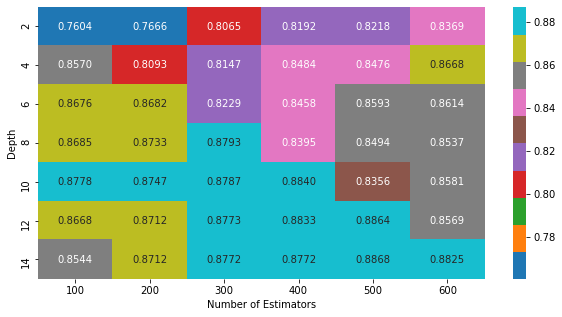

In [68]:
# Find the optimal value of depth and estimators
# This may take several minutes(even hour/s) to run

rf_train(x_train_bow, x_cv_bow, y_train, y_cv)

##### 6.1.2 BoW Random Forest on Test Data

The accuracy of the model is: 88.54481341930948
The macro f1_score of the model is: 80.51304197604821
The micro f1_score of the model is: 88.54481341930948
The precision_score of the model is: 78.19514697521741
The recall_score of the model is: 83.80827125389116
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.61      0.77      0.68     14414
    Positive       0.95      0.91      0.93     76619

    accuracy                           0.89     91033
   macro avg       0.78      0.84      0.81     91033
weighted avg       0.90      0.89      0.89     91033



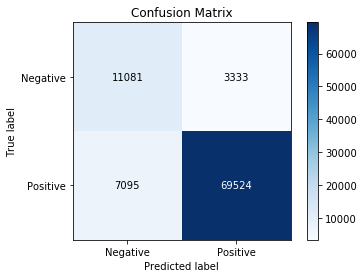

In [69]:
# Testing the final model

rf_test(x_train_bow, y_train, x_test_bow, y_test, optimal_estimators=600, optimal_depth=12)

Feature Importance 	 Features
0.0110			best
0.0093			great
0.0073			high recommend
0.0064			perfect
0.0062			disappoint
0.0061			love
0.0053			return
0.0052			away
0.0050			tast
0.0048			excel
0.0046			wast
0.0043			easi
0.0042			mayb
0.0039			favorit
0.0039			delici
0.0039			even
0.0037			bad
0.0037			wonder
0.0037			quick
0.0036			compani


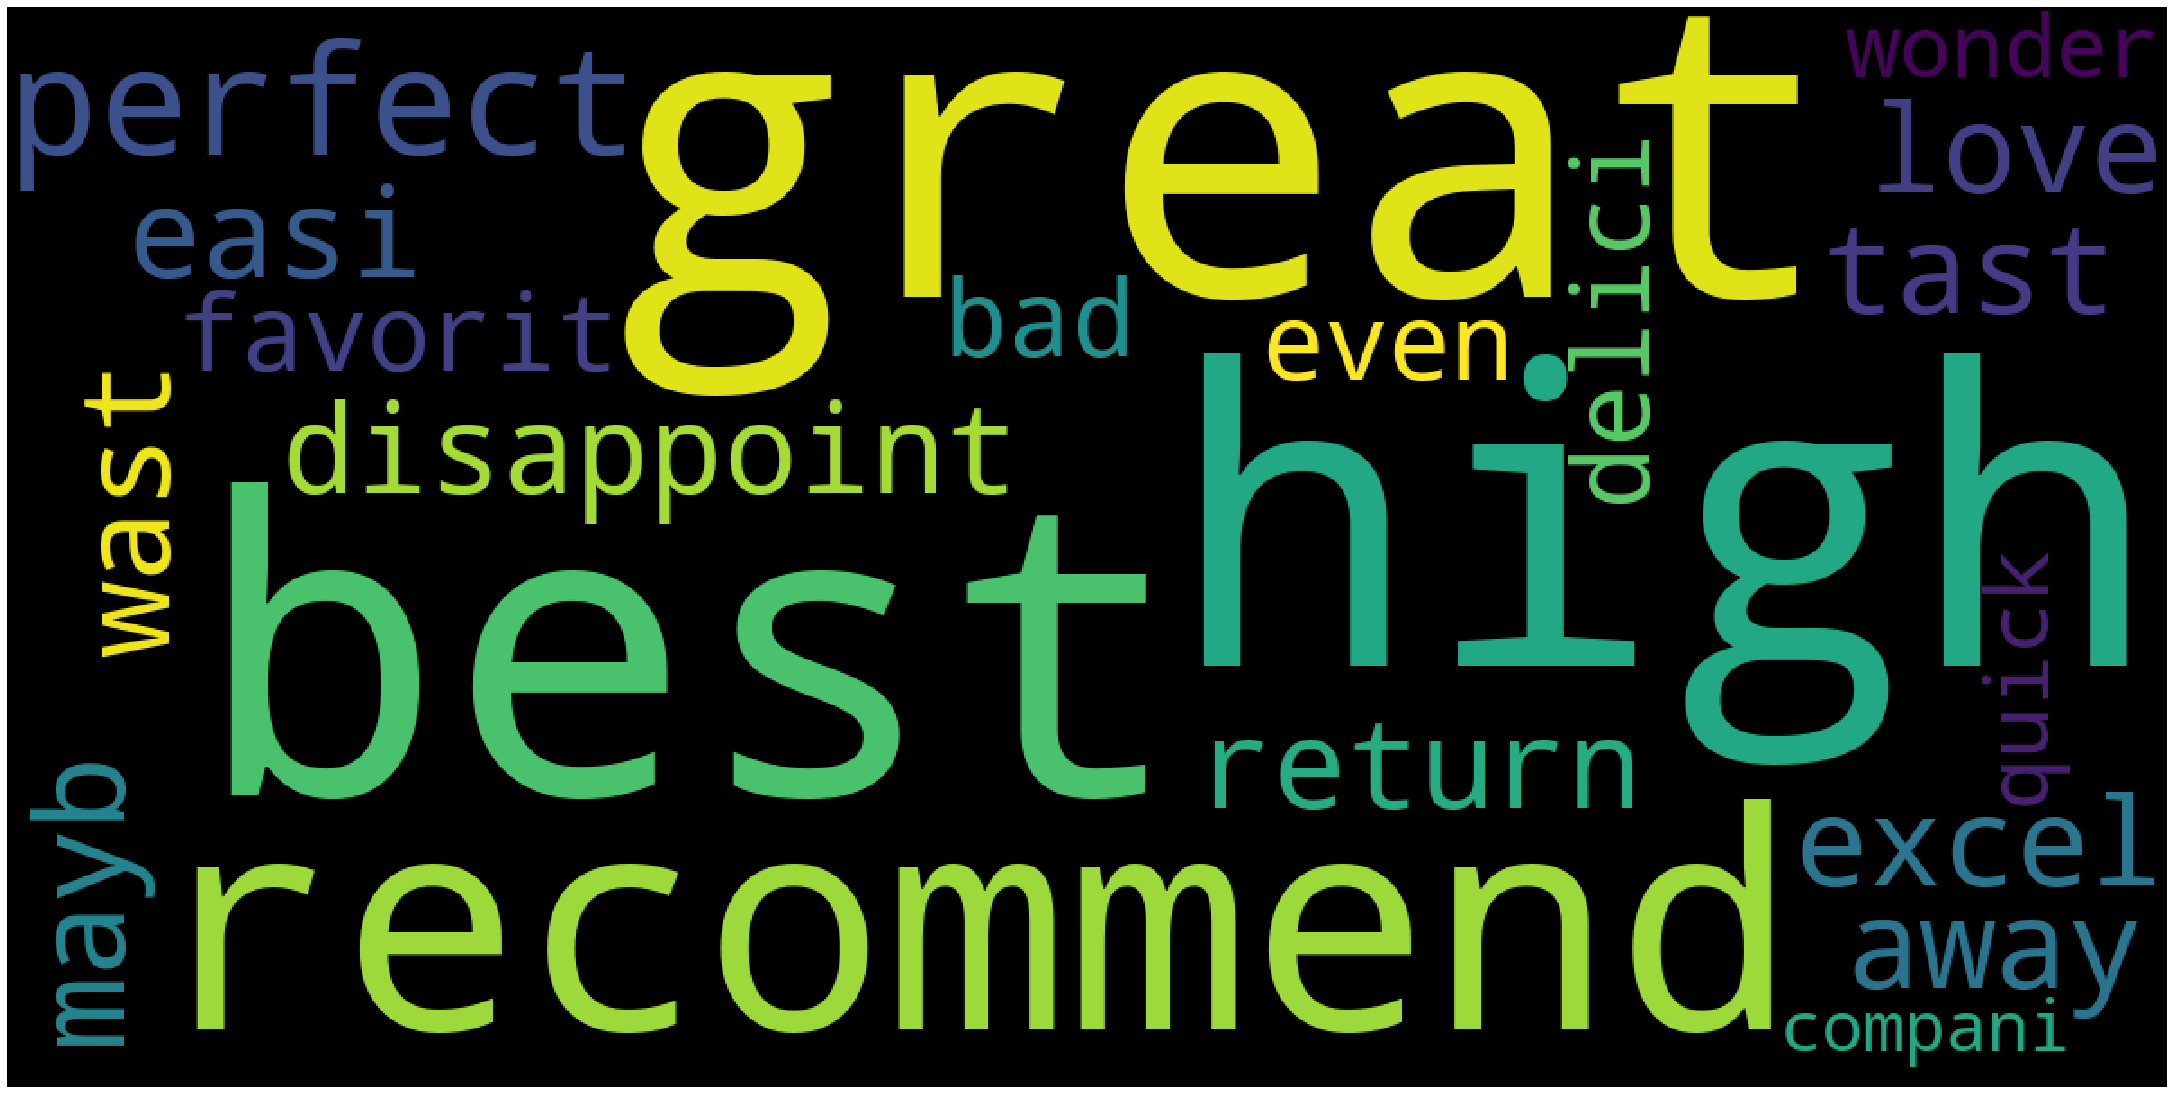

In [74]:
top_features(x_train_bow, y_train, count_vect, optimal_estimators=600, optimal_depth=12)

### 6.2 Term Frequency - Inverse Document Frequency (tf-idf)

##### 6.2.1 TF-IDF Random Forest on Train Data

FOR estimators = 100 and depth = 2
The accuracy of the model is: 73.62504577077993
The f1_score of the model is: 62.30702604669277
The precision_score of the model is: 61.50360806945119
The recall_score of the model is: 68.1681433361154
FOR estimators = 100 and depth = 4
The accuracy of the model is: 78.69522763334554
The f1_score of the model is: 67.54741699955574
The precision_score of the model is: 65.72975589435828
The recall_score of the model is: 72.81114567909263
FOR estimators = 100 and depth = 6
The accuracy of the model is: 78.57805443671427
The f1_score of the model is: 68.3226924566597
The precision_score of the model is: 66.42682424258564
The recall_score of the model is: 74.81895182100956
FOR estimators = 100 and depth = 8
The accuracy of the model is: 82.17380690833639
The f1_score of the model is: 71.97616103341926
The precision_score of the model is: 69.61969049985908
The recall_score of the model is: 77.17258063319392
FOR estimators = 100 and depth = 10
The accuracy o

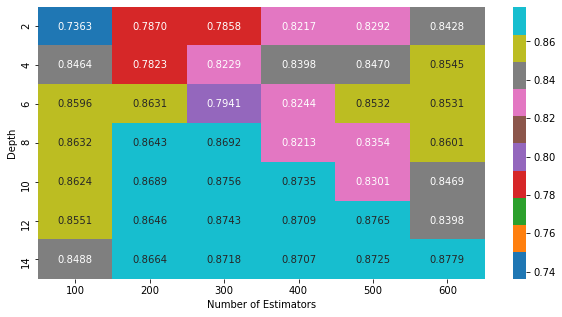

In [75]:
# Find the optimal value of depth and estimators
# This may take several minutes to run

rf_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv)

##### 6.2.2 TF-IDF Random Forest on Test Data

The accuracy of the model is: 88.29874880537827
The macro f1_score of the model is: 79.88124742286993
The micro f1_score of the model is: 88.29874880537827
The precision_score of the model is: 77.80267169552064
The recall_score of the model is: 82.72709174563386
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.61      0.75      0.67     14414
    Positive       0.95      0.91      0.93     76619

    accuracy                           0.88     91033
   macro avg       0.78      0.83      0.80     91033
weighted avg       0.90      0.88      0.89     91033



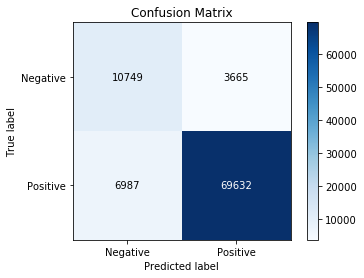

In [76]:
# Testing the final model

rf_test(x_train_tfidf, y_train, x_test_tfidf, y_test, optimal_estimators=600, optimal_depth=14)

Feature Importance 	 Features
0.0000			orang
0.0000			hair
0.0000			yummi
0.0000			yet
0.0000			year
0.0000			would
0.0000			worth
0.0000			work
0.0000			wonder
0.0000			without
0.0000			wish
0.0000			wife
0.0000			whole
0.0000			white
0.0000			wheat
0.0000			went
0.0000			well
0.0000			weight
0.0000			week
0.0000			way


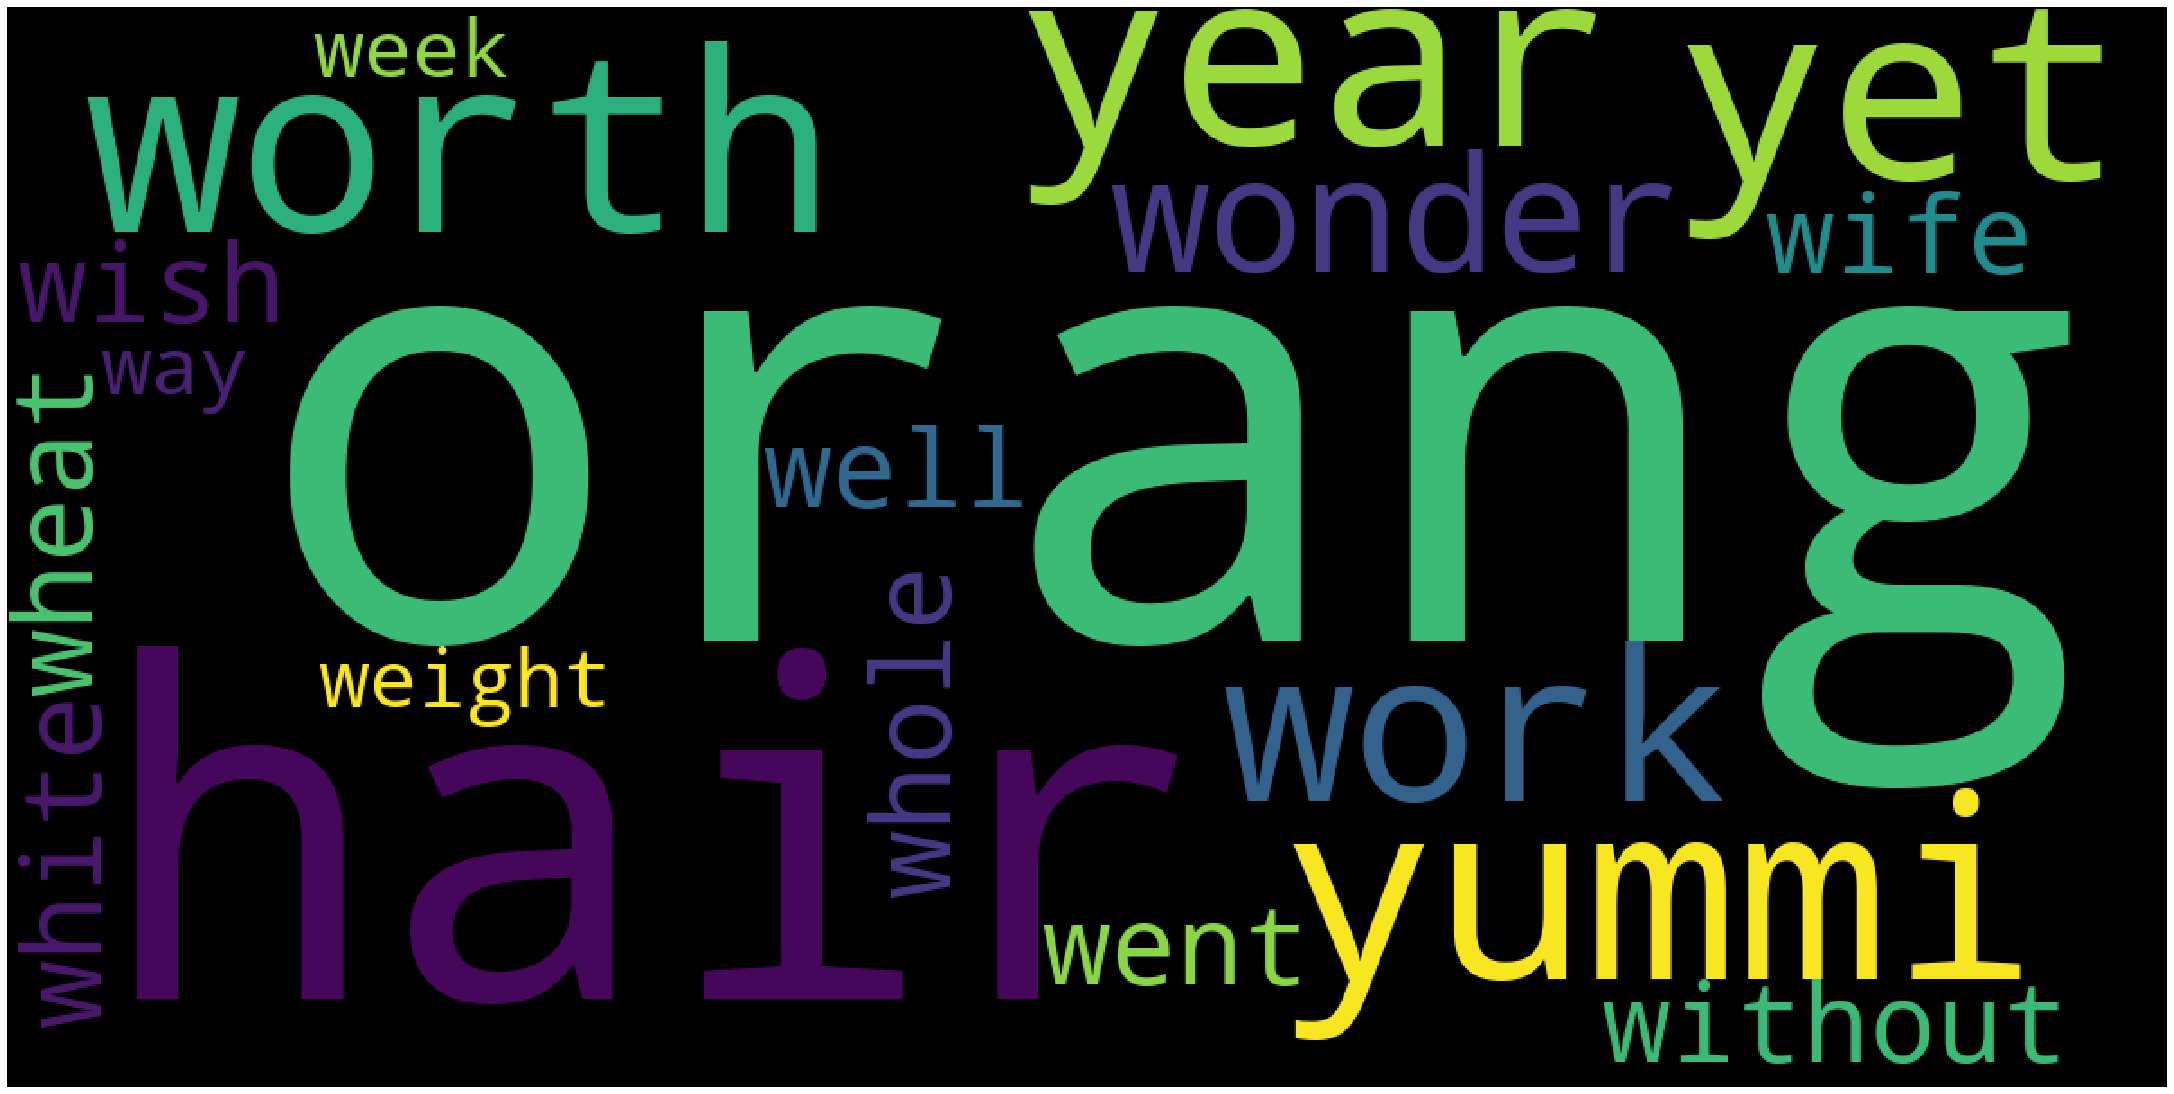

In [77]:
top_features(x_train_tfidf, y_train, tfidf_vect, optimal_estimators=600, optimal_depth=14)

### 6.3 Average word2Vec

##### 6.3.1 Avg W2V Random Forest on Train Data

FOR estimators = 100 and depth = 2
The accuracy of the model is: 75.01647748077627
The f1_score of the model is: 66.22897593419124
The precision_score of the model is: 65.26889860087739
The recall_score of the model is: 75.73982338656047
FOR estimators = 100 and depth = 4
The accuracy of the model is: 77.87989747345296
The f1_score of the model is: 69.0354916637149
The precision_score of the model is: 67.28344968157998
The recall_score of the model is: 77.99664423240354
FOR estimators = 100 and depth = 6
The accuracy of the model is: 79.26278530452826
The f1_score of the model is: 70.43008339220845
The precision_score of the model is: 68.33749770061497
The recall_score of the model is: 79.04204274996486
FOR estimators = 100 and depth = 8
The accuracy of the model is: 81.39143170999634
The f1_score of the model is: 72.51958390485787
The precision_score of the model is: 69.98950752495257
The recall_score of the model is: 80.25582759000358
FOR estimators = 100 and depth = 10
The accuracy 

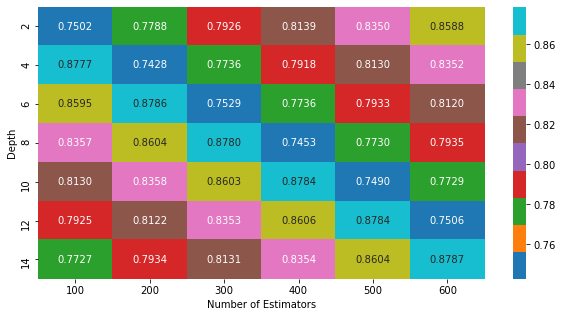

In [78]:
# Find the optimal value of depth and estimators
# This may take several minutes to run

rf_train(x_train_avgw2v, x_cv_avgw2v, y_train, y_cv)

##### 6.3.2 Avg W2V Random Forest on Test Data

The accuracy of the model is: 88.0790482572254
The macro f1_score of the model is: 77.7335753910616
The micro f1_score of the model is: 88.0790482572254
The precision_score of the model is: 77.61503411864882
The recall_score of the model is: 77.85397699793562
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.62      0.63      0.63     14414
    Positive       0.93      0.93      0.93     76619

    accuracy                           0.88     91033
   macro avg       0.78      0.78      0.78     91033
weighted avg       0.88      0.88      0.88     91033



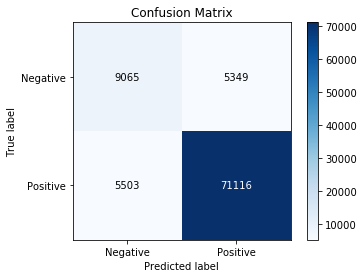

In [79]:
# Testing the final model

rf_test(x_train_avgw2v, y_train, x_test_avgw2v, y_test, optimal_estimators=600, optimal_depth=14)

### 6.4 TF-IDF Weighed Word2Vec

##### 6.4.1 TF-IDF W2V Random Forest on Train Data

FOR estimators = 100 and depth = 2
The accuracy of the model is: 66.15403393140485
The f1_score of the model is: 58.38168447786059
The precision_score of the model is: 60.39926677076595
The recall_score of the model is: 69.09753499140531
FOR estimators = 100 and depth = 4
The accuracy of the model is: 72.05785426583668
The f1_score of the model is: 62.91222729212718
The precision_score of the model is: 62.73968124867048
The recall_score of the model is: 71.89330065456792
FOR estimators = 100 and depth = 6
The accuracy of the model is: 73.96924203588429
The f1_score of the model is: 64.5239147024756
The precision_score of the model is: 63.75977231163483
The recall_score of the model is: 72.9878746176816
FOR estimators = 100 and depth = 8
The accuracy of the model is: 76.08080068351032
The f1_score of the model is: 66.3754431481039
The precision_score of the model is: 65.02797381517857
The recall_score of the model is: 74.22016246724374
FOR estimators = 100 and depth = 10
The accuracy of

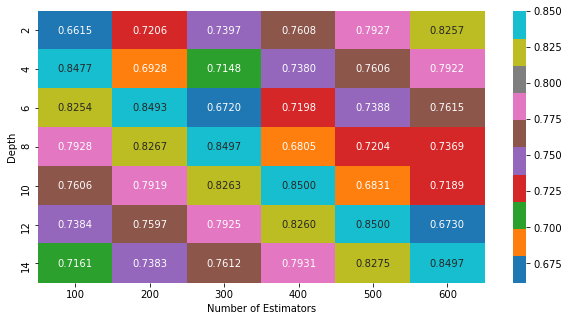

In [80]:
# Find the optimal value of depth and estimators
# This may take several minutes to run

rf_train(x_train_tfidfw2v, x_cv_tfidfw2v, y_train, y_cv)

##### 6.4.2 TF-IDF W2V Random Forest on Test Data

The accuracy of the model is: 85.35476146012985
The macro f1_score of the model is: 71.37363457162576
The micro f1_score of the model is: 85.35476146012985
The precision_score of the model is: 72.35648591473627
The recall_score of the model is: 70.5354488263801
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.54      0.49      0.51     14414
    Positive       0.91      0.92      0.91     76619

    accuracy                           0.85     91033
   macro avg       0.72      0.71      0.71     91033
weighted avg       0.85      0.85      0.85     91033



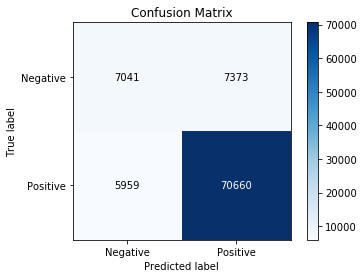

In [81]:
# Testing the final model

rf_test(x_train_tfidfw2v, y_train, x_test_tfidfw2v, y_test, optimal_estimators=400, optimal_depth=14)